# Epsilon ablation studies
In this notebook we present the code used for ablation studies published in our paper. **By default, precomputed results will be loaded** and printed out. **If you wish to run the ablations from scratch**, change the `results_dir` directory name from `release_results` to any other name you please.

In [1]:
import os
import json
import data
import itertools

import numpy as np
import pickle as pkl
import seaborn as sns
from tqdm import trange
from prettytable import PrettyTable
import matplotlib.pyplot as plt


import torch.nn as nn

from utils import batchify
from argparse import Namespace
from model import AWDRNNModel
from train import train, evaluate
from utils import get_batch
from multilinear import MultiLinear
from custom_rnn import CustomRNNCell, CustomRNN
from weight_drop import ParameterListWeightDrop
from epsilon_utils import prepare_seed, prepare_recepies, compute_stats, plot_results

In [2]:
# Change to a different name if you would like to run ablation tests from scratch
results_dir = './release_results'

In [3]:
# Prepare a fixed batch of data
file_list=os.listdir("train_logs_single_run/")
log_dflt = json.load(open('train_logs_single_run/' + file_list[0], 'r'))
args = Namespace(**log_dflt)
corpus = data.Corpus(args.data)

ntokens = len(corpus.dictionary)
batch_size = 256

train_eval_data = batchify(corpus.train, batch_size, args, "cpu")
x, _ = get_batch(train_eval_data, 0, args, evaluation=True)

In [4]:
len(train_eval_data)

3631

## Weight ablations

In this ablation study we verify how much does the performance of epsilon metric change depending on the chosen weights. Since we can only run epsilon computation for NAS-Bench-NLP only on CPU, we perform this study only for 1000 data points.

In [5]:
weight_range = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
it = 0
for (weight_l, weight_h) in itertools.product(weight_range, weight_range):
    
    if weight_h>weight_l:
        save_dir = '{}/NLP/Ablation/Weights/Weight_{}_{}/BS{}/'.format(results_dir, weight_l, weight_h, batch_size)
        os.makedirs(save_dir, exist_ok=True)
        if os.path.exists(save_dir+'Data'):
            # Load precomputed results
            data_file = open(save_dir+'Data','rb')
            data = pkl.load(data_file)
            score = data["score"]
            accs = data["accs"]
            nparams = data["nparams"]
        else:
            accs = []
            nparams = []
            score = []
            for i in trange(5000):
                file = file_list[i]
                log = json.load(open('train_logs_single_run/' + file, 'r'))
                args = Namespace(**log)

                # Build the model
                network = AWDRNNModel(args.model,
                                      ntokens,
                                      args.emsize,
                                      args.nhid,
                                      args.nlayers,
                                      args.dropout,
                                      args.dropouth,
                                      args.dropouti,
                                      args.dropoute,
                                      args.wdrop,
                                      args.tied,
                                      args.recepie,
                                      verbose=False)
                preds = []
                for weight in [weight_l, weight_h]:
                    # Initialize
                    prepare_seed(21)
                    def initialize_resnet(m):
                        if type(m)==MultiLinear:
                            for par in m.weights_raw:
                                nn.init.constant_(par, weight)
                        elif type(m)==CustomRNNCell:
                            for par in m.parameters():
                                nn.init.constant_(par, weight)
                        elif type(m)==nn.modules.linear.Linear:
                            nn.init.constant_(m.weight, weight)
                        elif type(m)==nn.modules.container.ParameterList:
                            for par in m.parameters():
                                nn.init.constant_(par, weight)
                        elif type(m)==CustomRNN:
                            initialize_resnet(m.cell)
                        elif type(m)==ParameterListWeightDrop:
                            initialize_resnet(m.module)
                        elif type(m)==nn.modules.container.ModuleDict:
                            for sub_m in m:
                                initialize_resnet(sub_m)
                        elif type(m)==nn.modules.container.ModuleList:
                            for sub_m in m:
                                initialize_resnet(sub_m)
                        elif type(m)==AWDRNNModel:
                            initialize_resnet(m.rnns)

                    network.apply(initialize_resnet)
                    network.eval()
                    hidden = network.init_hidden(batch_size, weight)
                    # Take care of embedding is not constant
                    nn.init.uniform_(network.encoder.weight, 0, 1)
                    _, _, raw_output, _ = network(x, hidden=hidden, return_h=True)
                    pred = raw_output[-1][:,:,0].flatten()
                    pred = pred.numpy()
                    pred_min = np.nanmin(pred)
                    pred_max = np.nanmax(pred)
                    pred_norm = (pred - pred_min)/(pred_max - pred_min)
                    preds.append(pred_norm)

                # Compute the score
                preds = np.array(preds)
                preds[np.where(preds==0)] = np.nan
                mae = np.nanmean(np.abs(preds[0,:]-preds[1,:]))
                mean = np.nanmean(preds)

                score.append(mae/mean)
                nparams.append(args.num_params)
                try:
                    accs.append(log['test_losses'][-1])
                except:
                    accs.append(np.nan) 

            save_dic = {}
            save_dic["score"] = score
            save_dic["accs"] = accs
            save_dic["nparams"] = nparams
            pkl.dump(save_dic, open(save_dir + "Data", "wb"))
            
        if it==0:
            # Make the table
            headers = ["Weights", "Archs", "Spearman (global)", "Spearman (top-10%)", "Kendall (global)", "Kendall (top-10%)", "Top-10%/top-10%", "Top-64/top-5%"]
            table = PrettyTable(headers)
        stats, remain = compute_stats(score, accs)
        stats_print = ["[{}, {}]".format(weight_l, weight_h), remain] + stats        
        table.add_row(stats_print)
        it+=1
        
#         score_plot = np.array(score)[np.array(score)>0.00001]
#         accs_plot = np.array(accs)[np.array(score)>0.00001]
#         nparams_plot = np.array(nparams)[np.array(score)>0.00001]
        
#         plot_results(score=score_plot,
#                      accs=accs_plot,
#                      nparams=nparams_plot,
#                      top10=False,
#                      log_scale=True,
#                      save_dir=save_dir,
#                      save_name="Epsilon_{}_{}".format(weight_l, weight_h))
    

In [6]:
import pandas as pd
pd.DataFrame(table.rows)

,0,1,2,3,4,5,6,7
0,"[1e-07, 1e-06]",1663,-0.14,0.25,-0.10,0.14,0.00,0.00
1,"[1e-07, 1e-05]",2211,-0.30,0.60,-0.20,0.46,1.82,0.00
2,"[1e-07, 0.0001]",2325,-0.35,0.53,-0.24,0.40,0.43,1.00
3,"[1e-07, 0.001]",2304,-0.40,0.52,-0.27,0.39,3.03,1.00
4,"[1e-07, 0.01]",914,-0.49,0.02,-0.34,0.02,3.30,1.00
5,"[1e-07, 0.1]",465,-0.30,0.26,-0.21,0.18,14.89,7.00
6,"[1e-07, 1]",395,-0.12,0.11,-0.08,0.03,12.50,7.00
7,"[1e-06, 1e-05]",2806,-0.21,0.55,-0.13,0.40,1.07,0.00
8,"[1e-06, 0.0001]",3234,-0.24,0.41,-0.16,0.30,0.62,0.00
9,"[1e-06, 0.001]",3211,-0.33,0.32,-0.22,0.24,4.67,1.00


In [15]:
import pandas as pd
pd.DataFrame(table.rows)

,0,1,2,3,4,5,6,7
0,"[1e-07, 1e-06]",2393,-0.24,0.32,-0.16,0.22,0.00,0.00
1,"[1e-07, 1e-05]",2391,-0.22,0.52,-0.15,0.39,1.67,0.00
2,"[1e-07, 0.0001]",2388,-0.35,0.49,-0.24,0.37,0.42,1.00
3,"[1e-07, 0.001]",2332,-0.42,0.50,-0.29,0.37,2.99,1.00
4,"[1e-07, 0.01]",1215,-0.30,0.13,-0.21,0.09,4.20,1.00
5,"[1e-07, 0.1]",585,-0.49,0.55,-0.36,0.44,1.69,1.00
6,"[1e-07, 1]",403,-0.12,0.08,-0.08,-0.00,12.20,7.00
7,"[1e-06, 1e-05]",3286,-0.11,0.49,-0.07,0.36,0.91,0.00
8,"[1e-06, 0.0001]",3283,-0.24,0.47,-0.16,0.34,0.62,0.00
9,"[1e-06, 0.001]",3226,-0.33,0.44,-0.23,0.33,4.64,1.00


In [5]:
# table

Weights,Archs,Overall Spearman,Top-10% Spearman,Top-10%/top-10%,Top-64/top-5%
"[1e-07, 1e-06]",484,-0.21,-0.20,4.35,3.00
"[1e-07, 1e-05]",484,-0.27,-0.08,31.25,6.00
"[1e-07, 0.0001]",482,-0.34,-0.03,28.89,7.00
"[1e-07, 0.001]",471,-0.44,0.14,34.04,7.00
"[1e-07, 0.01]",245,-0.33,-0.12,47.62,8.00
"[1e-07, 0.1]",123,-0.40,0.14,30.77,7.00
"[1e-07, 1]",90,0.01,-0.32,11.11,4.00
"[1e-06, 1e-05]",642,-0.09,-0.09,16.92,6.00
"[1e-06, 0.0001]",642,-0.23,0.01,25.42,9.00
"[1e-06, 0.001]",628,-0.36,-0.13,28.57,8.00


## Embedding ablations

In [7]:
embedding_names = ["uniform_positive_0.1",
                   "uniform_positive_1",
                   "uniform_centered_0.1",
                   "uniform_centered_1",
                   "random_0.1",
                   "random_1"]

In [15]:
weight_l = 1e-5
weight_h = 1e-3
it = 0
for embedding_name in embedding_names:
    save_dir = '{}/NLP/Ablation/Embedding/Embed_{}/'.format(results_dir, embedding_name)
    os.makedirs(save_dir, exist_ok=True)
    if os.path.exists(save_dir+'Data'):
        # Load precomputed results
        data_file = open(save_dir+'Data','rb')
        data = pkl.load(data_file)
        score = data["score"]
        accs = data["accs"]
        nparams = data["nparams"]
    else:
        accs = []
        nparams = []
        score = []
        for i in trange(1000):
            file = file_list[i]
            log = json.load(open('train_logs_single_run/' + file, 'r'))
            args = Namespace(**log)

            # Build the model
            network = AWDRNNModel(args.model,
                                  ntokens,
                                  args.emsize,
                                  args.nhid,
                                  args.nlayers,
                                  args.dropout,
                                  args.dropouth,
                                  args.dropouti,
                                  args.dropoute,
                                  args.wdrop,
                                  args.tied,
                                  args.recepie,
                                  verbose=False)
            preds = []
            for weight in [weight_l, weight_h]:
                # Initialize
                prepare_seed(21)
                def initialize_resnet(m):
                    if type(m)==MultiLinear:
                        for par in m.weights_raw:
                            nn.init.constant_(par, weight)
                    elif type(m)==CustomRNNCell:
                        for par in m.parameters():
                            nn.init.constant_(par, weight)
                    elif type(m)==nn.modules.linear.Linear:
                        nn.init.constant_(m.weight, weight)
                    elif type(m)==nn.modules.container.ParameterList:
                        for par in m.parameters():
                            nn.init.constant_(par, weight)
                    elif type(m)==CustomRNN:
                        initialize_resnet(m.cell)
                    elif type(m)==ParameterListWeightDrop:
                        initialize_resnet(m.module)
                    elif type(m)==nn.modules.container.ModuleDict:
                        for sub_m in m:
                            initialize_resnet(sub_m)
                    elif type(m)==nn.modules.container.ModuleList:
                        for sub_m in m:
                            initialize_resnet(sub_m)
                    elif type(m)==AWDRNNModel:
                        initialize_resnet(m.rnns)

                network.apply(initialize_resnet)
                network.eval()
                hidden = network.init_hidden(batch_size, weight)
                
                # Initialise embedding
                if embedding_name=="uniform_positive_0.1":
                    nn.init.uniform_(network.encoder.weight, 0, 0.1)
                elif embedding_name=="uniform_positive_1":
                    nn.init.uniform_(network.encoder.weight, 0, 1)
                elif embedding_name=="uniform_centered_0.1":
                    nn.init.uniform_(network.encoder.weight, -0.1, 0.1)
                elif embedding_name=="uniform_centered_1":
                    nn.init.uniform_(network.encoder.weight, -1, 1)
                elif embedding_name=="random_0.1":
                    nn.init.normal_(network.encoder.weight, mean=0.0, std=0.1)
                elif embedding_name=="random_1":
                    nn.init.normal_(network.encoder.weight, mean=0.0, std=1)
                    
                _, _, raw_output, _ = network(x, hidden=hidden, return_h=True)
                pred = raw_output[-1][:,:,0].flatten()
                pred = pred.numpy()
                pred_min = np.nanmin(pred)
                pred_max = np.nanmax(pred)
                pred_norm = (pred - pred_min)/(pred_max - pred_min)
                preds.append(pred_norm)

            # Compute the score
            preds = np.array(preds)
            preds[np.where(preds==0)] = np.nan
            mae = np.nanmean(np.abs(preds[0,:]-preds[1,:]))
            mean = np.nanmean(preds)

            score.append(mae/mean)
            nparams.append(args.num_params)
            try:
                accs.append(log['test_losses'][-1])
            except:
                accs.append(np.nan) 

        save_dic = {}
        save_dic["score"] = score
        save_dic["accs"] = accs
        save_dic["nparams"] = nparams
        pkl.dump(save_dic, open(save_dir + "Data", "wb"))

    if it==0:
        # Make the table
        headers = ["Data", "Archs", "Spearman (global)", "Spearman (top-10%)", "Kendall (global)", "Kendall (top-10%)", "Top-10%/top-10%", "Top-64/top-5%"]
        table = PrettyTable(headers, align='l')
    stats, remain = compute_stats(score, accs)
    stats_print = [embedding_name, remain] + stats       
    table.add_row(stats_print)
    it+=1

#     plot_results(score=score,
#                  accs=accs,
#                  nparams=nparams,
#                  top10=False,
#                  log_scale=True,
#                  save_dir=save_dir,
#                  save_name="Epsilon_{}".format(embedding_name))
    

In [16]:
import pandas as pd
pd.DataFrame(table.rows)

,0,1,2,3,4,5,6,7
0,uniform_positive_0.1,782,-0.38,0.17,-0.26,0.15,3.80,2.00
1,uniform_positive_1,776,-0.37,0.21,-0.26,0.18,2.56,2.00
2,uniform_centered_0.1,783,-0.40,0.18,-0.28,0.15,2.53,2.00
3,uniform_centered_1,782,-0.46,0.18,-0.33,0.16,1.27,1.00
4,random_0.1,783,-0.42,0.18,-0.29,0.15,2.53,2.00
5,random_1,782,-0.47,0.19,-0.33,0.16,1.27,1.00


## Batch size

In [74]:
batch_size_range = [8, 16, 32, 64, 128, 256, 512, 1024]

weight_l = 1e-5
weight_h = 1e-3
it = 0

batch_all_spearman_all = []
batch_top10_spearman_all = []
batch_all_kendall_all = []
batch_top10_kendall_all = []
batch_top10top10_all = []
batch_top64top5_all = []

for batch_size in batch_size_range:
    batch_all_spearman = []
    batch_top10_spearman = []
    batch_all_kendall = []
    batch_top10_kendall = []
    batch_top10top10 = []
    batch_top64top5 = []
    
    for it in range(3):
        # Load the data batch
        if it==0:
            train_eval_data = batchify(corpus.train, batch_size, args, "cpu")
            ind = np.random.choice(range(len(train_eval_data)-args.bptt), 5, replace=False)
        x, _ = get_batch(train_eval_data, ind[it], args, evaluation=True)

        save_dir = '{}/NLP/Ablation/Batch Size/BS{}/'.format(results_dir, batch_size)
        os.makedirs(save_dir, exist_ok=True)

        if os.path.exists(save_dir+'Data_' + str(it)):
            # Load precomputed results
            data_file = open(save_dir + 'Data_' + str(it),'rb')
            input_data = pkl.load(data_file)
            score = input_data["score"]
            accs = input_data["accs"]
            nparams = input_data["nparams"]
        else:
            accs = []
            nparams = []
            score = []
            for i in trange(1000):
                file = file_list[i]
                log = json.load(open('train_logs_single_run/' + file, 'r'))
                args = Namespace(**log)

                # Build the model
                network = AWDRNNModel(args.model,
                                      ntokens,
                                      args.emsize,
                                      args.nhid,
                                      args.nlayers,
                                      args.dropout,
                                      args.dropouth,
                                      args.dropouti,
                                      args.dropoute,
                                      args.wdrop,
                                      args.tied,
                                      args.recepie,
                                      verbose=False)
                preds = []
                for weight in [weight_l, weight_h]:
                    # Initialize
                    prepare_seed(21)
                    def initialize_resnet(m):
                        if type(m)==MultiLinear:
                            for par in m.weights_raw:
                                nn.init.constant_(par, weight)
                        elif type(m)==CustomRNNCell:
                            for par in m.parameters():
                                nn.init.constant_(par, weight)
                        elif type(m)==nn.modules.linear.Linear:
                            nn.init.constant_(m.weight, weight)
                        elif type(m)==nn.modules.container.ParameterList:
                            for par in m.parameters():
                                nn.init.constant_(par, weight)
                        elif type(m)==CustomRNN:
                            initialize_resnet(m.cell)
                        elif type(m)==ParameterListWeightDrop:
                            initialize_resnet(m.module)
                        elif type(m)==nn.modules.container.ModuleDict:
                            for sub_m in m:
                                initialize_resnet(sub_m)
                        elif type(m)==nn.modules.container.ModuleList:
                            for sub_m in m:
                                initialize_resnet(sub_m)
                        elif type(m)==AWDRNNModel:
                            initialize_resnet(m.rnns)

                    network.apply(initialize_resnet)
                    network.eval()
                    hidden = network.init_hidden(batch_size, weight)
                    nn.init.uniform_(network.encoder.weight, 0, 1)
                    _, _, raw_output, _ = network(x, hidden=hidden, return_h=True)
                    pred = raw_output[-1][:,:,0].flatten()
                    pred = pred.numpy()
                    pred_min = np.nanmin(pred)
                    pred_max = np.nanmax(pred)
                    pred_norm = (pred - pred_min)/(pred_max - pred_min)
                    preds.append(pred_norm)

                # Compute the score
                preds = np.array(preds)
                preds[np.where(preds==0)] = np.nan
                mae = np.nanmean(np.abs(preds[0,:]-preds[1,:]))
                mean = np.nanmean(preds)

                score.append(mae/mean)
                nparams.append(args.num_params)
                try:
                    accs.append(log['test_losses'][-1])
                except:
                    accs.append(np.nan)

            save_dic = {}
            save_dic["score"] = score
            save_dic["accs"] = accs
            save_dic["nparams"] = nparams
            pkl.dump(save_dic, open(save_dir + "Data_" + str(it), "wb"))

        stats, _ = compute_stats(score, accs, reverse=True, raw=True)
        batch_all_spearman.append(stats[0])
        batch_top10_spearman.append(stats[1])
        batch_all_kendall.append(stats[2])
        batch_top10_kendall.append(stats[3])
        batch_top10top10.append(stats[4])
        batch_top64top5.append(stats[5])

    batch_all_spearman_all.append(batch_all_spearman)
    batch_top10_spearman_all.append(batch_top10_spearman)
    batch_all_kendall_all.append(batch_all_kendall)
    batch_top10_kendall_all.append(batch_top10_kendall)
    batch_top10top10_all.append(batch_top10top10)
    batch_top64top5_all.append(batch_top64top5)

  1%|▏                                        | 6/1000 [00:03<10:52,  1.52it/s]/home/gracheva/miniconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in true_divide
/home/gracheva/miniconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: Mean of empty slice
 68%|██████████████████████████▎            | 675/1000 [37:44<21:25,  3.95s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 73%|████████████████████████████▍          | 728/1000 [41:13<15:24,  3.40s/it]


RuntimeError: [enforce fail at CPUAllocator.cpp:65] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 86016000 bytes. Error code 12 (Cannot allocate memory)

In [70]:
from matplotlib.ticker import MaxNLocator
def plot_experiment(exp_list, filename):
    fig = plt.figure(figsize=(7.2,4.45))
    ax = fig.add_subplot(111)
    def plot_exp(exp, label):
        exp = np.array(exp)
        q_75 = np.nanquantile(exp, .75, axis=1)
        q_25 = np.nanquantile(exp, .25, axis=1)
        mean = np.nanmedian(exp, axis=1)
        ax.plot(range(len(mean)), mean, label=label)
        ax.fill_between(range(len(mean)), np.nanmin(exp, axis=1), np.nanmax(exp, axis=1), alpha=0.1)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.set_xticklabels(['','8','16','32'])
#         ax.set_xticklabels(['','8','16','32','64','128','256','512','1024'])
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                     ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(16)
    for exp,ename in exp_list:
        plot_exp(exp,ename)
    plt.grid()
    plt.xlabel('Batch size', fontsize=18)
    plt.ylabel(r'Spearman $\rho$', fontsize=18)
#     plt.ylim(0.3,1)
    plt.legend(fontsize=16)
    plt.savefig(filename,
                bbox_inches='tight', 
                dpi=300)
    plt.show()

/home/gracheva/miniconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


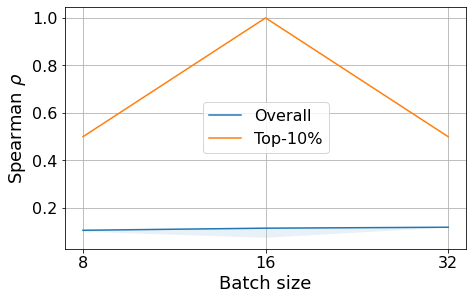

In [71]:
save_dir = './release_results/NLP/Ablation/Batch Size/'
filename = save_dir+"BatchSize_Spearman_NLP_Single.png"
plot_experiment([(batch_all_spearman_all,'Overall'), (batch_top10_spearman_all,'Top-10%')], filename)